## Segmentation  avec MedSAM.

MedSAM est une version spécialisée du Segment Anything Model (SAM), entraînée sur des milliers d'images médicales. Il permet une segmentation en Zero-Shot : sans réentraînement spécifique, il peut délimiter une structure basée sur une simple prompt (point cliqué, bounding box).

Objectif : Évaluer la performance (Dice Score, le Jaccard Index (IoU)) de MedSAM pour la segmentation de tumeur cérébrale .

In [ ]:
import torch
import os
import numpy as np
import cv2
from utils import BratsDataset, MRIPreprocessingImage, MedSamMetrics, MetricsLivePlot


In [2]:
img_dir = "D:/marchine_learning/Projet/Segmentation/BraTS2023_Preprocessed/input_data_128/train/images"
mask_dir = "D:/marchine_learning/Projet/Segmentation/BraTS2023_Preprocessed/input_data_128/train/masks"

In [3]:
train_dataset = BratsDataset(img_dir, mask_dir, normalization=False)

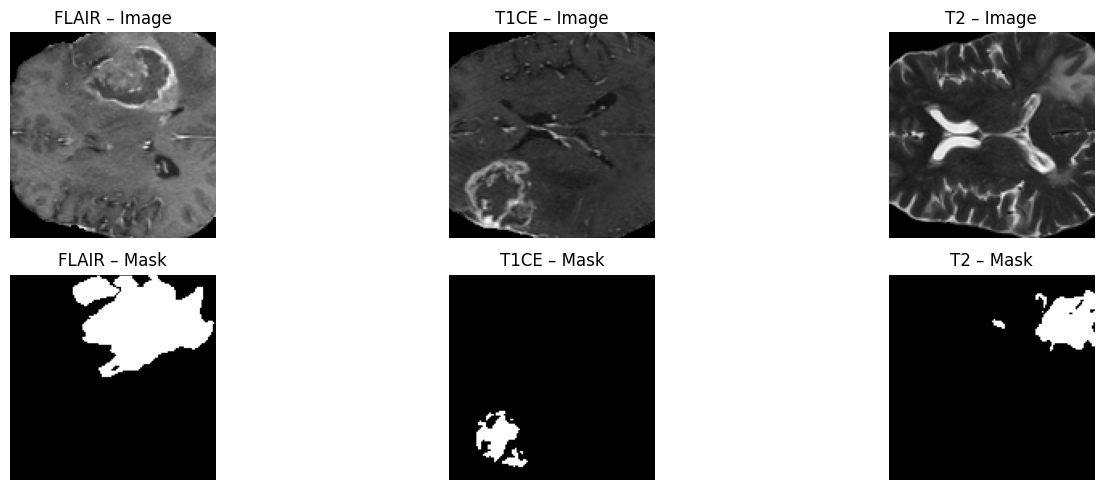

In [4]:
trainer = MRIPreprocessingImage(train_dataset, n_samples=25)
trainer.plot_samples()

In [5]:
from segment_anything import SamPredictor, sam_model_registry

MODEL_TYPE = "vit_b"
CHECKPOINT_PATH = "D:/marchine_learning/Projet/Segmentation/MedSam/model/medsam_vit_b.pth"
DEVICE = "cpu"
print(f"Chargement de MedSAM sur : {DEVICE}")
if os.path.exists(CHECKPOINT_PATH):

    sam = sam_model_registry[MODEL_TYPE]()
    state_dict = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))

    # 3. Appliquer les poids
    sam.load_state_dict(state_dict)
    sam.to(device=DEVICE)
    sam.eval()

    # 5. Créer le prédicteur
    predictor = SamPredictor(sam)
else:
    print('Techarger le poit du model sur https://github.com/bowang-lab/MedSAM?tab=readme-ov-file')
    
# if image is load clear it
def clear_image(predictor, verbose = 0):
    if predictor.is_image_set:
        predictor.reset_image()
        if verbose > 0:
            print(predictor.is_image_set)

Chargement de MedSAM sur : cpu


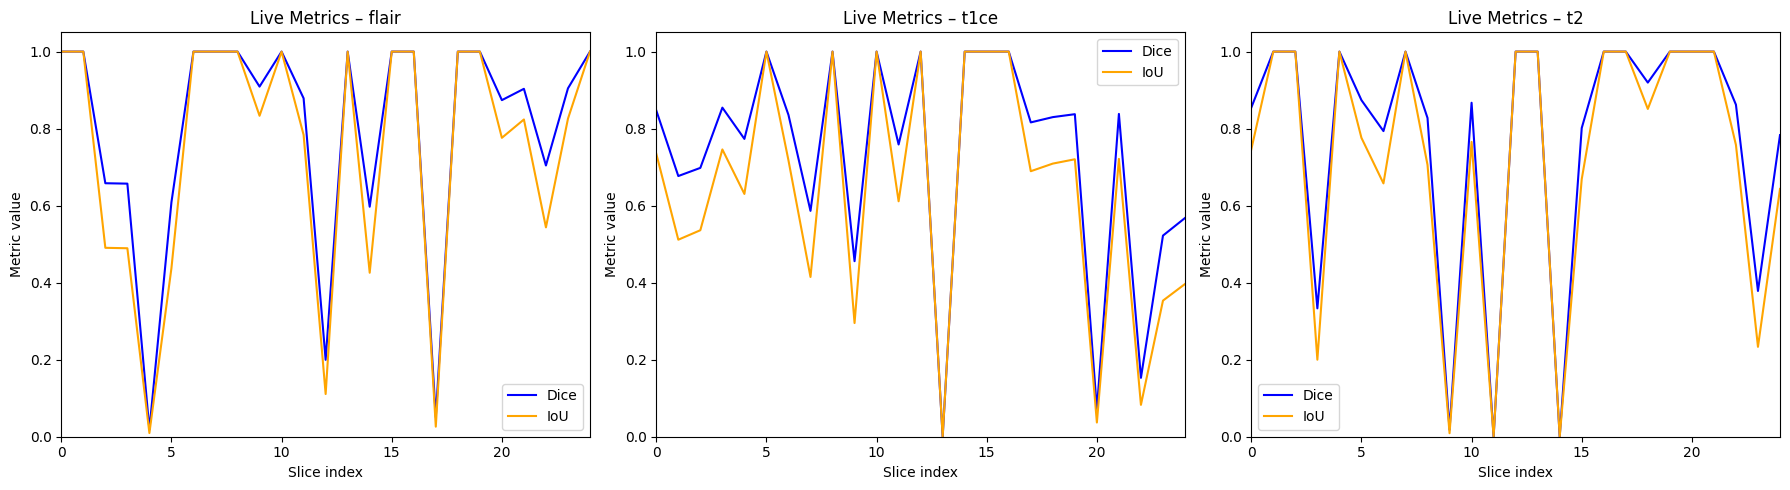

Scores moyens Dice : {'flair': np.float64(0.7985822753870911), 't1ce': np.float64(0.7248896310559028), 't2': np.float64(0.7725127337875378)}
Scores moyens IoU  : {'flair': np.float64(0.7430339177777617), 't1ce': np.float64(0.6363122757952105), 't2': np.float64(0.7205873725855967)}


In [6]:
modalities = ["flair", "t1ce", "t2"]
results_dice = {m: [] for m in modalities}
results_iou  = {m: [] for m in modalities}
results  = {m: [] for m in modalities}
liveplot = MetricsLivePlot(modalities)

for modality in modalities:
    img_slices, mask_slices = trainer.sample_data(modality = "t1ce")

    for j, (img_slice, mask_ref) in enumerate(zip(img_slices, mask_slices)):
        # Définir box prompt meilleur resultat que les points
        white_rows, white_cols = np.where(mask_ref.astype(bool))
        if len(white_rows) == 0: 
            input_box = None
        else:
            x_min, y_min = min(white_cols), min(white_rows)
            x_max, y_max = max(white_cols), max(white_rows)
            input_box = np.array([(x_min, y_min), (x_max, y_max)])

        # Tranform en RGB pour SAM
        slide_norm = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)
        image_rgb = cv2.cvtColor(slide_norm, cv2.COLOR_GRAY2RGB)

        clear_image(predictor)
        predictor.set_image(image_rgb)

        # Inférence SAM (CPU lent)
        masks_sam, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=True,
        )

        metrics = MedSamMetrics(img_slice, mask_ref, masks_sam, scores)

        # Calcul métriques
        dice = metrics.dice()
        jacal = metrics.iou()
        liveplot.update(modality, j, dice, jacal)

        # Save metrics
        results_dice[modality].append(dice)
        results_iou[modality].append(jacal)
        results[modality].append(metrics)

# --- Moyenne des scores ---
avg_dice = {mod: np.mean(results_dice[mod]) for mod in modalities}
avg_iou  = {mod: np.mean(results_iou[mod]) for mod in modalities}

print("Scores moyens Dice :", avg_dice)
print("Scores moyens IoU  :", avg_iou)


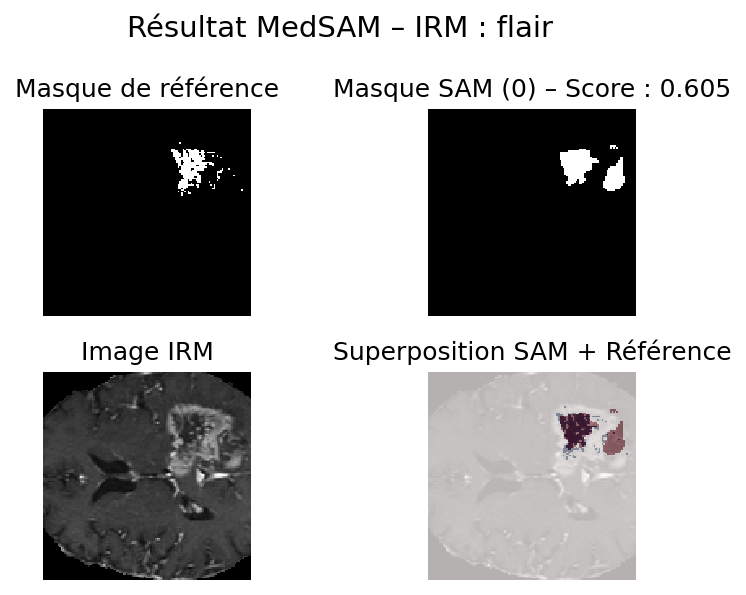

In [10]:
results["flair"][5].plot_masks(modality="flair")